### Problem Formulation

Let a robot's trajectory through its environment be represented by a sequence of $N$ poses: $\mathbf{p}_1, \mathbf{p}_2, \ldots, \mathbf{p}_N$.  Each pose lies on a manifold: $\mathbf{p}_i \in \mathcal{M}$.  Simple examples of manifolds used in Graph SLAM include 1-D, 2-D, and 3-D space, i.e., $\mathbb{R}$, $\mathbb{R}^2$, and $\mathbb{R}^3$.  These environments are *rectilinear*, meaning that there is no concept of orientation.  By contrast, in $SE(2)$ problem settings a robot's pose consists of its location in $\mathbb{R}^2$ and its orientation $\theta$.  Similarly, in $SE(3)$ a robot's pose consists of its location in $\mathbb{R}^3$ and its orientation, which can be represented via Euler angles, quaternions, or $SO(3)$ rotation matrices.  

As the robot explores its environment, it collects a set of $M$ measurements $\mathcal{Z} = \{\mathbf{z}_j\}$.  Examples of such measurements include odometry, GPS, and IMU data.  Given a set of poses $\mathbf{p}_1, \ldots, \mathbf{p}_N$, we can compute the estimated measurement $\hat{\mathbf{z}}_j(\mathbf{p}_1, \ldots, \mathbf{p}_N)$.  We can then compute the *residual* $\mathbf{e}_j(\mathbf{z}_j, \hat{\mathbf{z}}_j)$ for measurement $j$.  The formula for the residual depends on the type of measurement.  As an example, let $\mathbf{z}_1$ be an odometry measurement that was collected when the robot traveled from $\mathbf{p}_1$ to $\mathbf{p}_2$.  The expected measurement and the residual are computed as

\begin{align}
    \hat{\mathbf{z}}_1(\mathbf{p}_1, \mathbf{p}_2) &= \mathbf{p}_2 \ominus \mathbf{p}_1 \\
    \mathbf{e}_1(\mathbf{z}_1, \hat{\mathbf{z}}_1) &= \mathbf{z}_1 \ominus \hat{\mathbf{z}}_1 = \mathbf{z}_1 \ominus (\mathbf{p}_2 \ominus \mathbf{p}_1),
\end{align}

where the $\ominus$ operator indicates inverse pose composition.  We model measurement $\mathbf{z}_j$ as having independent Gaussian noise with zero mean and covariance matrix $\Omega_j^{-1}$; we refer to $\Omega_j$ as the *information matrix* for measurement $j$.  That is,

\begin{equation}
    p(\mathbf{z}_j \ | \ \mathbf{p}_1, \ldots, \mathbf{p}_N) = \eta_j \exp \left( (-\mathbf{e}_j(\mathbf{z}_j, \hat{\mathbf{z}}_j))^T \Omega_j \mathbf{e}_j(\mathbf{z}_j, \hat{\mathbf{z}}_j) \right),
\end{equation}

where $\eta_j$ is the normalization constant.

The objective of Graph SLAM is to find the maximum likelihood set of poses given the measurements $\mathcal{Z} = \{\mathbf{z}_j\}$; in other words, we want to find 

\begin{equation}
    \underset{\mathbf{p}_1, \ldots, \mathbf{p}_N}{\operatorname{arg\,max}} \ p(\mathbf{p}_1, \ldots, \mathbf{p}_N \ | \ \mathcal{Z}) 
\end{equation}

Using Bayes' rule, we can write this probability as

\begin{align}
    p(\mathbf{p}_1, \ldots, \mathbf{p}_N \ | \ \mathcal{Z}) &= \frac{p( \mathcal{Z} \ | \ \mathbf{p}_1, \ldots, \mathbf{p}_N) p(\mathbf{p}_1, \ldots, \mathbf{p}_N) }{ p(\mathcal{Z}) } \\
    &\propto p( \mathcal{Z} \ | \ \mathbf{p}_1, \ldots, \mathbf{p}_N),
\end{align}

since $p(\mathcal{Z})$ is a constant (albeit, an unknown constant) and we assume that $p(\mathbf{p}_1, \ldots, \mathbf{p}_N)$ is uniformly distributed.  Therefore, we can simplify the Graph SLAM optimization as follows:

\begin{align}
    \underset{\mathbf{p}_1, \ldots, \mathbf{p}_N}{\operatorname{arg\,max}} \ p(\mathbf{p}_1, \ldots, \mathbf{p}_N \ | \ \mathcal{Z}) &= \underset{\mathbf{p}_1, \ldots, \mathbf{p}_N}{\operatorname{arg\,max}} \ p( \mathcal{Z} \ | \ \mathbf{p}_1, \ldots, \mathbf{p}_N) \\
    &= \underset{\mathbf{p}_1, \ldots, \mathbf{p}_N}{\operatorname{arg\,max}} \prod_{j=1}^M p(\mathbf{z}_j \ | \ \mathbf{p}_1, \ldots, \mathbf{p}_N) \\
    &= \underset{\mathbf{p}_1, \ldots, \mathbf{p}_N}{\operatorname{arg\,max}} \prod_{j=1}^M \exp \left( -(\mathbf{e}_j(\mathbf{z}_j, \hat{\mathbf{z}}_j))^T \Omega_j \mathbf{e}_j(\mathbf{z}_j, \hat{\mathbf{z}}_j) \right) \\
    &= \underset{\mathbf{p}_1, \ldots, \mathbf{p}_N}{\operatorname{arg\,min}} \sum_{j=1}^M (\mathbf{e}_j(\mathbf{z}_j, \hat{\mathbf{z}}_j))^T \Omega_j \mathbf{e}_j(\mathbf{z}_j, \hat{\mathbf{z}}_j).
\end{align}

We define

\begin{equation}
    \chi^2 := \sum_{j=1}^M (\mathbf{e}_j(\mathbf{z}_j, \hat{\mathbf{z}}_j))^T \Omega_j \mathbf{e}_j(\mathbf{z}_j, \hat{\mathbf{z}}_j),
\end{equation}

and this is what we seek to minimize.


### Dimensionality and Pose Representation

Before proceeding further, it is helpful to discuss the dimensionality of the problem.  We have:

* A set of $N$ poses $\mathbf{p}_1, \mathbf{p}_2, \ldots, \mathbf{p}_N$, where each pose lies on the manifold $\mathcal{M}$

  * Each pose $\mathbf{p}_i$ is represented as a vector in (a subset of) $\mathbb{R}^d$.  For example:
    * An $SE(2)$ pose is typically represented as $(x, y, \theta)$, and thus $d = 3$.
    * An $SE(3)$ pose is typically represented as $(x, y, z, q_x, q_y, q_z, q_w)$, where $(x, y, z)$ is a point in $\mathbb{R}^3$ and $(q_x, q_y, q_z, q_w)$ is a *quaternion*, and so $d = 7$.
  * We also need to be able to represent each pose compactly as a vector in (a subset of) $\mathbb{R}^c$.
    * Since an $SE(2)$ pose has three degrees of freedom, the $(x, y, \theta)$ representation is again sufficient and $c=3$.  
    * An $SE(3)$ pose only has six degrees of freedom, and we can represent it compactly as $(x, y, z, q_x, q_y, q_z)$, and thus $c=6$.
  * We use the $\boxplus$ operator to indicate pose composition when one or both of the poses are represented compactly.  The output can be a pose in $\mathcal{M}$ or a vector in $\mathbb{R}^c$, as required by context.

* A set of $M$ measurements $\mathcal{Z} = \{\mathbf{z}_1, \mathbf{z}_2, \ldots, \mathbf{z}_M\}$

  * Each measurement's dimensionality can be unique, and we will use $\bullet$ to denote a "wildcard" variable.
  * Measurement $\mathbf{z}_j \in \mathbb{R}^\bullet$ has an associated information matrix $\Omega_j \in \mathbb{R}^{\bullet \times \bullet}$ and residual function $\mathbf{e}_j(\mathbf{z}_j, \hat{\mathbf{z}}_j) = \mathbf{e}_j(\mathbf{z}_j, \mathbf{p}_1, \ldots, \mathbf{p}_N) \in \mathbb{R}^\bullet$.
  * A measurement could, in theory, constrain anywhere from 1 pose to all $N$ poses.  In practice, each measurement usually constrains only 1 or 2 poses.  


### Graph SLAM Algorithm

The "Graph" in Graph SLAM refers to the fact that we view the problem as a graph.  The graph has a set $\mathcal{V}$ of $N$ vertices, where each vertex $v_i$ has an associated pose $\mathbf{p}_i$.  Similarly, the graph has a set $\mathcal{E}$ of $M$ edges, where each edge $e_j$ has an associated measurement $\mathbf{z}_j$.  In practice, the edges in this graph are either unary (i.e., a loop) or binary.  (Note: $e_j$ refers to the edge in the graph associated with measurement $\mathbf{z}_j$, whereas $\mathbf{e}_j$ refers to the residual function associated with $\mathbf{z}_j$.)

We want to optimize

\begin{equation}
    \chi^2 = \sum_{e_j \in \mathcal{E}} \mathbf{e}_j^T \Omega_j \mathbf{e}_j.
\end{equation}

Let $\mathbf{x}_i \in \mathbb{R}^c$ be the compact representation of pose $\mathbf{p}_i \in \mathcal{M}$, and let

\begin{equation}
    \mathbf{x} := \begin{bmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \\ \vdots \\ \mathbf{x}_N \end{bmatrix} \in \mathbb{R}^{cN}
\end{equation}

We will solve this optimization problem iteratively.  Let

\begin{equation}
    \mathbf{x}^{k+1} := \mathbf{x}^k \boxplus \Delta \mathbf{x}^k = \begin{bmatrix} \mathbf{x}_1 \boxplus \Delta \mathbf{x}_1 \\ \mathbf{x}_2 \boxplus \Delta \mathbf{x}_2 \\ \vdots \\ \mathbf{x}_N \boxplus \Delta \mathbf{x}_2 \end{bmatrix}
\end{equation}

The $\chi^2$ error at iteration $k+1$ is

\begin{equation}
    \chi_{k+1} = \sum_{e_j \in \mathcal{E}} \underbrace{\left[ \mathbf{e}_j(\mathbf{x}^{k+1}) \right]^T}_{1 \times \bullet} \underbrace{\Omega_j}_{\bullet \times \bullet} \underbrace{\mathbf{e}_j(\mathbf{x}^{k+1})}_{\bullet \times 1}.
\end{equation}

We will linearize the errors as:

\begin{align}
    \mathbf{e}_j(\mathbf{x}^{k+1}) &= \mathbf{e}_j(\mathbf{x}^k \boxplus \Delta \mathbf{x}^k) \\
    &\approx \mathbf{e}_j(\mathbf{x}^{k}) + \frac{\partial}{\partial \Delta \mathbf{x}^k} \left[ \mathbf{e}_j(\mathbf{x}^k \boxplus \Delta \mathbf{x}^k) \right] \Delta \mathbf{x}^k \\
    &= \mathbf{e}_j(\mathbf{x}^{k}) + \left( \left. \frac{\partial \mathbf{e}_j(\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)} \right|_{\Delta \mathbf{x}^k = \mathbf{0}} \right) \frac{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial \Delta \mathbf{x}^k} \Delta \mathbf{x}^k.
\end{align}

Plugging this into the formula for $\chi^2$, we get:

\begin{align}
    \chi_{k+1}^2 &\approx \ \ \ \ \ \sum_{e_j \in \mathcal{E}} \underbrace{[ \mathbf{e}_j(\mathbf{x}^k)]^T}_{1 \times \bullet} \underbrace{\Omega_j}_{\bullet \times \bullet} \underbrace{\mathbf{e}_j(\mathbf{x}^k)}_{\bullet \times 1} \\
    &\hphantom{\approx} \ \ \ + \sum_{e_j \in \mathcal{E}} \underbrace{[ \mathbf{e}_j(\mathbf{x^k}) ]^T }_{1 \times \bullet} \underbrace{\Omega_j}_{\bullet \times \bullet} \underbrace{\left( \left. \frac{\partial \mathbf{e}_j(\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)} \right|_{\Delta \mathbf{x}^k = \mathbf{0}} \right)}_{\bullet \times dN} \underbrace{\frac{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial \Delta \mathbf{x}^k}}_{dN \times cN} \underbrace{\Delta \mathbf{x}^k}_{cN \times 1} \\
    &\hphantom{\approx} \ \ \ + \sum_{e_j \in \mathcal{E}} \underbrace{(\Delta \mathbf{x}^k)^T}_{1 \times cN} \underbrace{ \left( \frac{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial \Delta \mathbf{x}^k} \right)^T}_{cN \times dN} \underbrace{\left( \left. \frac{\partial \mathbf{e}_j(\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)} \right|_{\Delta \mathbf{x}^k = \mathbf{0}} \right)^T}_{dN \times \bullet} \underbrace{\Omega_j}_{\bullet \times \bullet} \underbrace{\left( \left. \frac{\partial \mathbf{e}_j(\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)} \right|_{\Delta \mathbf{x}^k = \mathbf{0}} \right)}_{\bullet \times dN} \underbrace{\frac{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial \Delta \mathbf{x}^k}}_{dN \times cN} \underbrace{\Delta \mathbf{x}^k}_{cN \times 1} \\
    &= \chi_k^2 + 2 \mathbf{b}^T \Delta \mathbf{x}^k + (\Delta \mathbf{x}^k)^T H \Delta \mathbf{x}^k,
\end{align}

where

\begin{align}
    \mathbf{b}^T &= \sum_{e_j \in \mathcal{E}} \underbrace{[ \mathbf{e}_j(\mathbf{x^k}) ]^T }_{1 \times \bullet} \underbrace{\Omega_j}_{\bullet \times \bullet} \underbrace{\left( \left. \frac{\partial \mathbf{e}_j(\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)} \right|_{\Delta \mathbf{x}^k = \mathbf{0}} \right)}_{\bullet \times dN} \underbrace{\frac{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial \Delta \mathbf{x}^k}}_{dN \times cN} \\
    H &= \sum_{e_j \in \mathcal{E}} \underbrace{ \left( \frac{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial \Delta \mathbf{x}^k} \right)^T}_{cN \times dN} \underbrace{\left( \left. \frac{\partial \mathbf{e}_j(\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)} \right|_{\Delta \mathbf{x}^k = \mathbf{0}} \right)^T}_{dN \times \bullet} \underbrace{\Omega_j}_{\bullet \times \bullet} \underbrace{\left( \left. \frac{\partial \mathbf{e}_j(\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)} \right|_{\Delta \mathbf{x}^k = \mathbf{0}} \right)}_{\bullet \times dN} \underbrace{\frac{\partial (\mathbf{x}^k \boxplus \Delta \mathbf{x}^k)}{\partial \Delta \mathbf{x}^k}}_{dN \times cN}.
\end{align}

Using this notation, we obtain the optimal update as

\begin{equation}
    \Delta \mathbf{x}^k = -H^{-1} \mathbf{b}.
\end{equation}

We apply this update to the poses and repeat until convergence.

In [1]:
from graphslam.load import load_g2o_se2

In [2]:
g = load_g2o_se2("input_INTEL2.g2o")

In [3]:
g.calc_chi2()

7191686.382493544

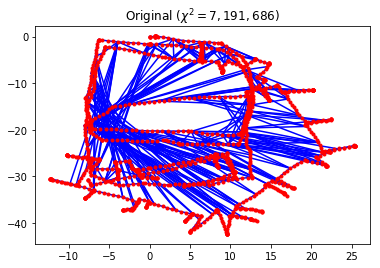

In [4]:
g.plot(title=r"Original ($\chi^2 = 7,191,686$)")


Iteration                chi^2        rel. change
---------                -----        -----------
        0         7191686.3825
        1       320031728.8624          43.500234


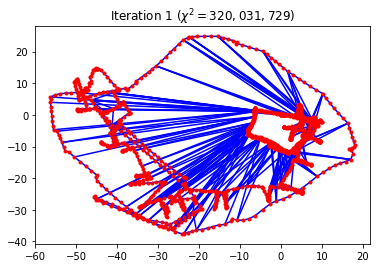

In [5]:
g.optimize(max_iter=1)

g.plot(title="Iteration 1 ($\chi^2 = 320,031,729$)")


Iteration                chi^2        rel. change
---------                -----        -----------
        0       320031728.8624
        1       125083004.3299          -0.609154


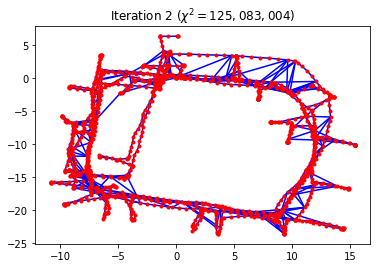

In [6]:
g.optimize(max_iter=1)

g.plot(title="Iteration 2 ($\chi^2 = 125,083,004$)")


Iteration                chi^2        rel. change
---------                -----        -----------
        0       125083004.3299
        1          338155.9074          -0.997297


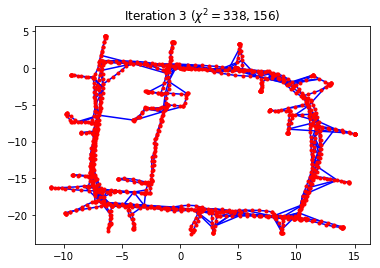

In [7]:
g.optimize(max_iter=1)

g.plot(title="Iteration 3 ($\chi^2 = 338,156$)")


Iteration                chi^2        rel. change
---------                -----        -----------
        0          338155.9074
        1             735.1344          -0.997826


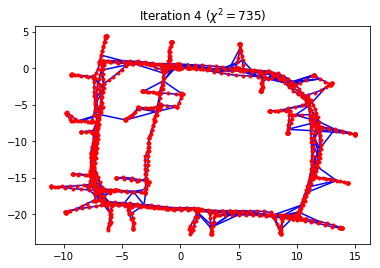

In [8]:
g.optimize(max_iter=1)

g.plot(title="Iteration 4 ($\chi^2 = 735$)")


Iteration                chi^2        rel. change
---------                -----        -----------
        0             735.1344
        1             215.8405          -0.706393


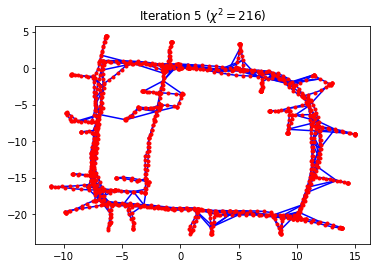

In [9]:
g.optimize(max_iter=1)

g.plot(title="Iteration 5 ($\chi^2 = 216$)")


Iteration                chi^2        rel. change
---------                -----        -----------
        0             215.8405
        1             215.8405          -0.000000


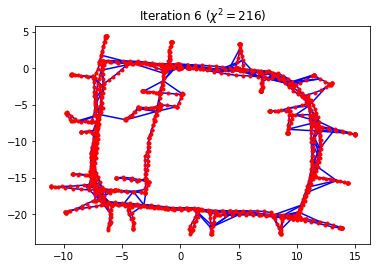

In [10]:
g.optimize(max_iter=1)

g.plot(title="Iteration 6 ($\chi^2 = 216$)")

In [11]:
g = load_g2o_se2("input_INTEL2.g2o")
g.optimize(max_iter=6)


Iteration                chi^2        rel. change
---------                -----        -----------
        0         7191686.3825
        1       320031728.8624          43.500234
        2       125083004.3299          -0.609154
        3          338155.9074          -0.997297
        4             735.1344          -0.997826
        5             215.8405          -0.706393
        6             215.8405          -0.000000


In [12]:
g = load_g2o_se2("input_INTEL2.g2o")
g.optimize(max_iter=6)


Iteration                chi^2        rel. change
---------                -----        -----------
        0         7191686.3825
        1       320031728.8624          43.500234
        2       125083004.3299          -0.609154
        3          338155.9074          -0.997297
        4             735.1344          -0.997826
        5             215.8405          -0.706393
        6             215.8405          -0.000000


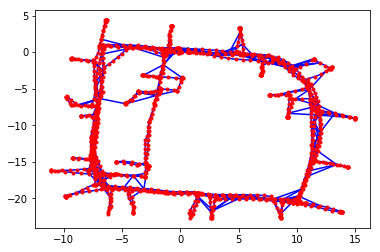

In [5]:
g.plot()

In [6]:
g.to_g2o("output_INTEL.g2o")

In [7]:
g2 = load_g2o_se2("output_INTEL.g2o")

In [8]:
g2.calc_chi2()

215.84048899001857